In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import sys
import scipy
import numpy as np
import sklearn
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.utils import resample

In [2]:
nonPCAWG_wgs_mut = pd.read_csv('./project_data/catalogs/WGS/WGS_Other.96.csv')

In [3]:
PCAWG_wgs_mut = pd.read_csv('./project_data/catalogs/WGS/WGS_PCAWG.96.csv')

In [4]:
### Aggregate mutation type and trinucleotides to one column
PCAWG_wgs_mut['tri_mut'] = PCAWG_wgs_mut[['Mutation type', 'Trinucleotide']].agg('_'.join, axis=1)
# 
nonPCAWG_wgs_mut['tri_mut'] = nonPCAWG_wgs_mut[['Mutation type', 'Trinucleotide']].agg('_'.join, axis=1)
# Concatenate both mutation count data sets
#total_wgs_mut = pd.concat([PCAWG_wgs_mut, nonPCAWG_wgs_mut], axis=1)
#total_wgs_mut.shape
#(96, 4651)
### Get cancer types
new_list = [re.sub(r'\:.*', '', i) for i in PCAWG_wgs_mut.columns]
# Transpose
PCAWG_wgs_mut_T = PCAWG_wgs_mut.T
# Rename columns
PCAWG_wgs_mut_T.columns = PCAWG_wgs_mut["tri_mut"]
PCAWG_wgs_mut_T["label"] = new_list[:]
PCAWG_wgs_mut_T = PCAWG_wgs_mut_T.iloc[2:,:] # we don't need to first 2 rows

In [5]:
X = PCAWG_wgs_mut_T.drop('label', axis=1).drop('tri_mut',axis=0).copy()

In [6]:
Y = PCAWG_wgs_mut_T['label'][0:-1].copy()

# Support Vector Machines
Milla Kortelainen & Laurens Veltman

In [7]:
#Methods
def svm_percentages(confusion_matrix): #converts confusion matrix absolut values to percentages
    confusion_matrix = confusion_matrix.T.astype(np.float)
    for prediction in range(len(confusion_matrix)):
        total = sum(confusion_matrix[prediction])
        if total == 0:
                pass
        for i in range(len(confusion_matrix[prediction])):
            if confusion_matrix[prediction][i] == 0:
                pass
            else:
                confusion_matrix[prediction][i] = np.round((confusion_matrix[prediction][i]/total)*100,1)
    return confusion_matrix.T


In [8]:
#Scaling data
scaled_X = scale(X)
X_train_scaled, X_test_scaled, Y_train, Y_test = train_test_split(scaled_X,Y, random_state=42)

In [9]:
clf_svm = SVC(random_state=42, C=1000, gamma = 'scale', kernel='rbf')
clf_svm.fit(X_train_scaled, Y_train)
clf_svm.score(X_test_scaled, Y_test) #Return the mean accuracy on the given test data and labels.

0.7107913669064748

In [10]:
cf = confusion_matrix(Y_test, clf_svm.predict(X_test_scaled))
cf_percentages = svm_percentages(cf)
cancer_types = sorted(Y_test.unique())


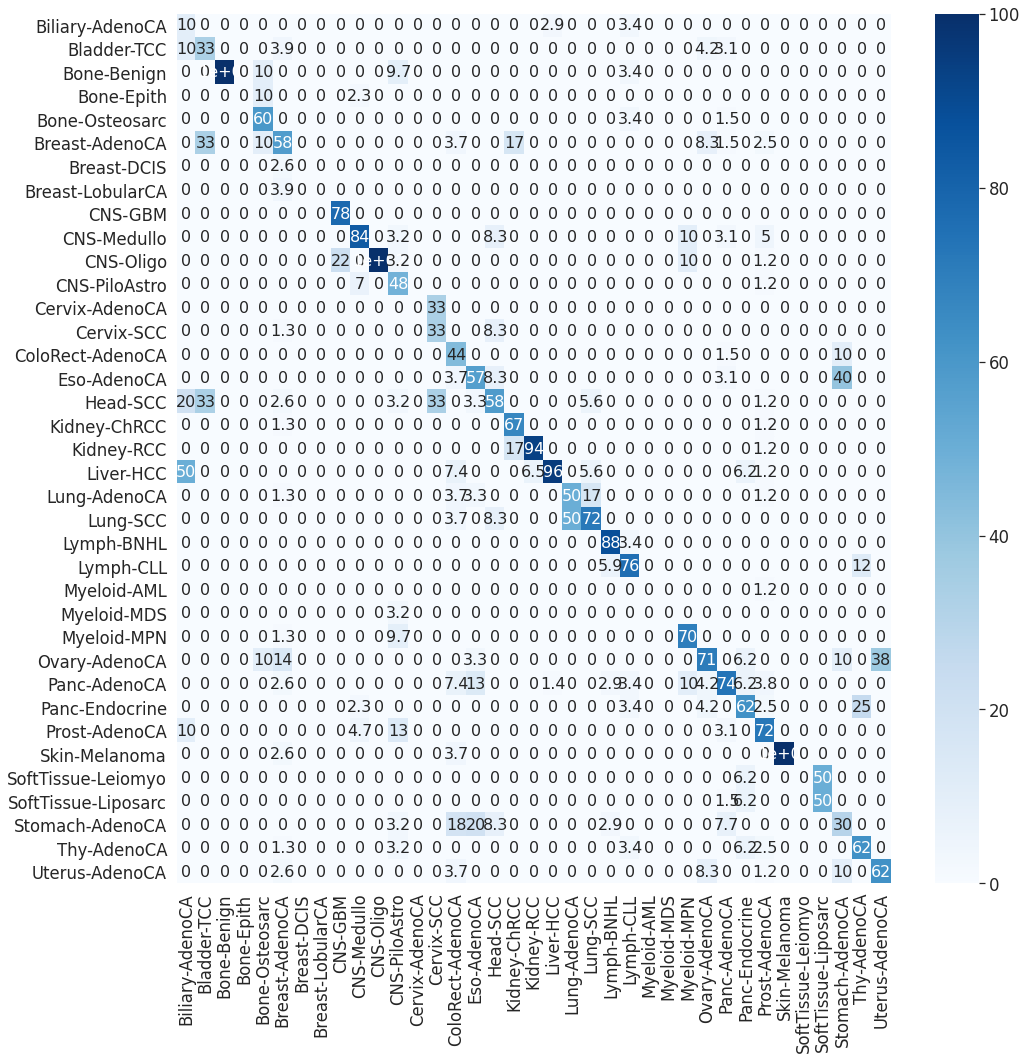

In [11]:
df = pd.DataFrame(cf_percentages, columns= cancer_types, index = cancer_types)
plt.figure(figsize=(16,16))
sns.set(font_scale=1.5) # for label size
sns.heatmap(df, annot=True, annot_kws={"size": 16}, cmap="Blues") # font size
plt.show()

In [12]:
#Central nervous system subgroup
sample_group = ('CNS-GBM','CNS-Medullo','CNS-Oligo','CNS-PiloAstro')
keys = []
CX = X.copy()
for key in CX.T.keys():
    for sample in sample_group:
        if sample in key:
            keys.append(key)
CX = CX.loc[[key for key in keys]]
CY = Y.copy()
CY = CY.loc[[key for key in keys]]
scaled_CX = scale(CX)
CX_train_scaled, CX_test_scaled, CY_train, CY_test = train_test_split(scaled_CX,CY, random_state=42)

In [13]:
clf_svm = SVC(random_state=42, C=1, gamma = 'scale', kernel='linear')
clf_svm.fit(CX_train_scaled, CY_train)
clf_svm.score(CX_test_scaled, CY_test) #Return the mean accuracy on the given test data and labels.

0.9054054054054054

In [14]:
cf = confusion_matrix(CY_test, clf_svm.predict(CX_test_scaled))
cf_percentages = svm_percentages(cf)
cancer_types = sorted(CY_test.unique())

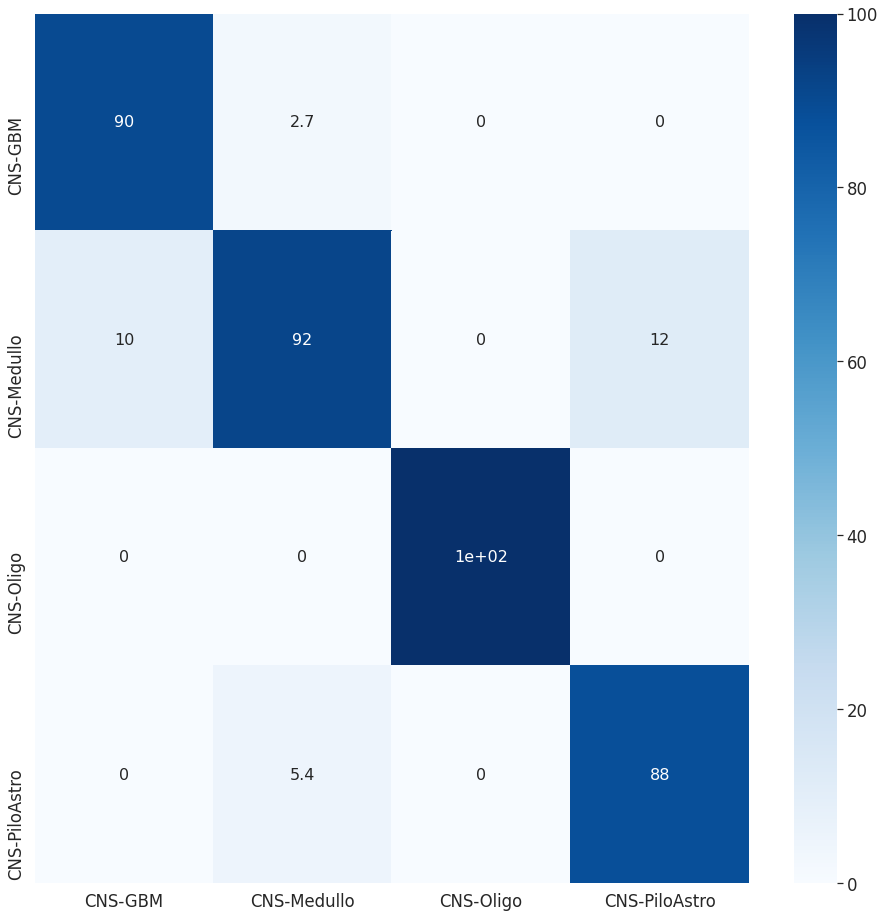

In [15]:
df = pd.DataFrame(cf_percentages, columns= cancer_types, index = cancer_types)
plt.figure(figsize=(16,16))
sns.set(font_scale=1.5) # for label size
sns.heatmap(df, annot=True, annot_kws={"size": 16}, cmap="Blues") # font size
plt.show()

## Grouping by organ

In [33]:
PCAWG_wgs_mut_T_organ = PCAWG_wgs_mut_T.copy()

In [34]:
organ_list = [x[0] for x in PCAWG_wgs_mut_T_organ.label.str.split('-')]

In [35]:
PCAWG_wgs_mut_T_organ['organ'] = organ_list

In [42]:
X_organ = PCAWG_wgs_mut_T_organ.drop('organ', axis=1).drop('tri_mut',axis=0).drop('label', axis=1).copy()

In [44]:
Y_organ = PCAWG_wgs_mut_T_organ['organ'][0:-1].copy()

In [45]:
#Scaling data
scaled_X_organ = scale(X_organ)
X_organ_train_scaled, X_organ_test_scaled, Y_organ_train, Y_organ_test = train_test_split(scaled_X_organ,Y_organ, random_state=42)

In [49]:
param_grid = [{ 'C':[0.5, 1, 10, 100], 
               'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] },
             ]
optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv = 5,
    scoring='accuracy',
    verbose = 0
)
optimal_params.fit(X_organ_train_scaled, Y_organ_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}


In [50]:
clf_svm = SVC(random_state=42, C=100, gamma = 'scale', kernel='linear')
clf_svm.fit(X_organ_train_scaled, Y_organ_train)
clf_svm.score(X_organ_test_scaled, Y_organ_test) #Return the mean accuracy on the given test data and labels.

0.7496402877697842

In [51]:
cf = confusion_matrix(Y_organ_test, clf_svm.predict(X_organ_test_scaled))
cf_percentages = svm_percentages(cf)
cancer_types = sorted(Y_organ_test.unique())

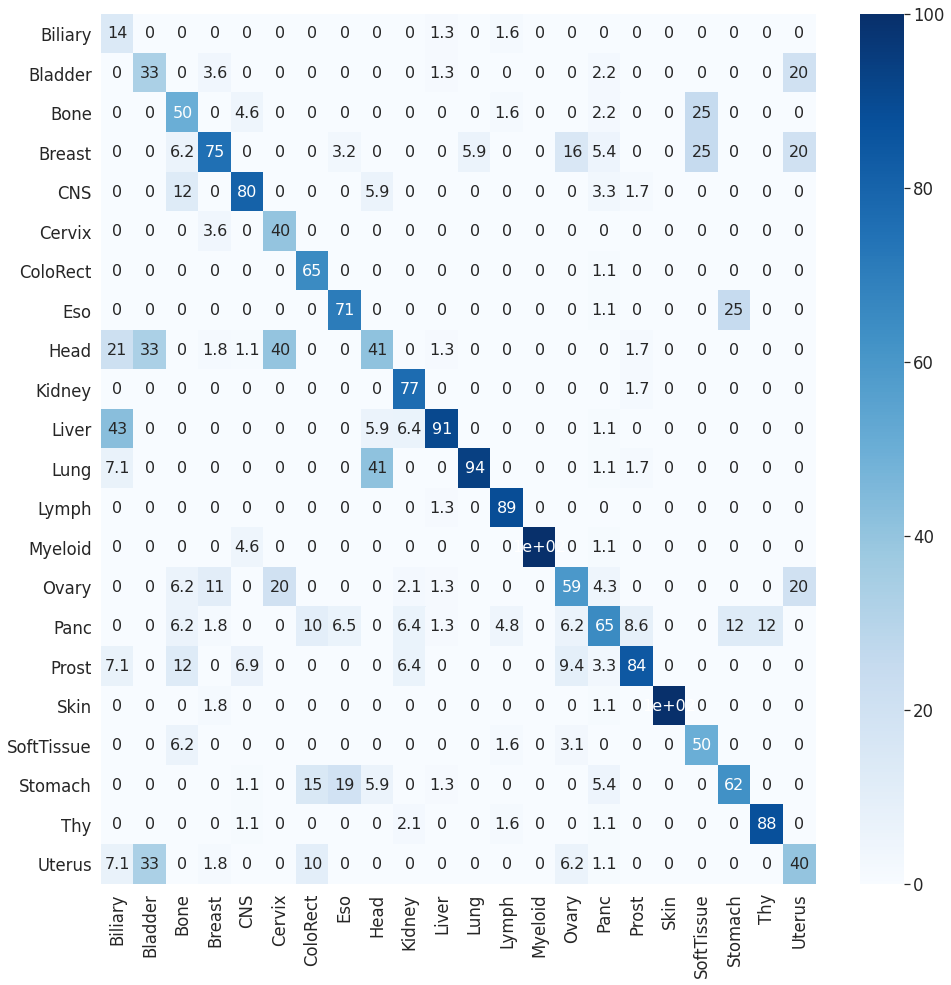

In [52]:
df = pd.DataFrame(cf_percentages, columns= cancer_types, index = cancer_types)
plt.figure(figsize=(16,16))
sns.set(font_scale=1.5) # for label size
sns.heatmap(df, annot=True, annot_kws={"size": 16}, cmap="Blues") # font size
plt.show()